# Missing Value Imputation 

This tutorial is about observing the performance comparison between some basic Missing Value (MV) imputation methods and concluding with MICE algorithm as the recommended one in practice.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

The used dataset is the [well-known Wine Dataset from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine) donated by Stefan Aeberhard. 

This dataset has 178 samples in 13 dimensions and depicts the characteristics of three different wines from different regions in Italy. In this tutorial our workflow is to replace some values with **None** values, while keeping the true values somewhere. Then trying different imputation methods and compare them with eachother and also with true values.

*PS: Of course for such purpose we do not need targets as our evaluation criteria will be clossness to the true values. Another setting of such experiment is to keep targets and compare MV imputation methods based on their prediction performance.*

In [2]:
# Read the data and split target and features

data = pd.read_csv('wine.csv').drop('Wine',axis=1)
data_orig = data.copy()

# You may want to have a pre-insight to the data using pd.scatter_matrix(data)

In [3]:
# Randomly choose a variable and 10% of its values to introduce missing values.
chosen_col = np.random.choice(data.columns)
missed_inds = np.random.choice(data.index,int(len(data)*.1)).tolist()

# Keep true values for further comaprisons.
true_col = data[chosen_col].copy()
data.loc[missed_inds,chosen_col] = np.nan

print(len(missed_inds),'samples of "'+chosen_col+'"','were randomly chosen for surgery :D\n')
print(pd.concat([true_col,data[chosen_col]],axis=1).head(10))

17 samples of "Nonflavanoid.phenols" were randomly chosen for surgery :D

   Nonflavanoid.phenols  Nonflavanoid.phenols
0                  0.28                  0.28
1                  0.26                  0.26
2                  0.30                  0.30
3                  0.24                  0.24
4                  0.39                  0.39
5                  0.34                  0.34
6                  0.30                   NaN
7                  0.31                  0.31
8                  0.29                   NaN
9                  0.22                  0.22


<br><br>The routine bellow applies a set of visualizations to the true and imputed values in comapre with each other and with "Flavanoids" for sake of inspecting methods.

In [4]:
# We choose "Flavanoids" feature for fairly comparing results of imputations. 

def inspect_my_method(imputed_data, chosen_col, true_col, missed_inds,method):
    rest = [ii for ii in data.index if ii not in missed_inds]
    imputed_col = imputed_data[chosen_col]
    plt.figure(figsize=(8,8))
    plt.plot(true_col.loc[missed_inds],imputed_data[chosen_col].loc[missed_inds],'*',markersize=10)
    plt.xlabel('True Values', fontsize=20)
    plt.ylabel('Imputed Values with '+method, fontsize=20)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.title('True Values', fontsize=20)
    plt.plot(true_col.loc[missed_inds],data['Flavanoids'].loc[missed_inds], 'ro', markersize=10, label = 'MVs-True')
    plt.plot(true_col.loc[rest],data['Flavanoids'].loc[rest], 'bo', markersize=10, label = 'Rest of Points', alpha=.5)
    plt.xlabel(chosen_col, fontsize=20)
    plt.ylabel('Flavanoids', fontsize=20)
    plt.legend()
    plt.subplot(122)
    plt.title('Imputed Values', fontsize=20)
    plt.plot(imputed_col.loc[missed_inds],data['Flavanoids'].loc[missed_inds], 'ro', markersize=10, label = 'MVs-Imputed')
    plt.plot(imputed_col.loc[rest],data['Flavanoids'].loc[rest], 'bo', markersize=10, label = 'Rest of Points', alpha=.5)
    plt.xlabel(chosen_col, fontsize=20)
    plt.ylabel('Flavanoids',fontsize=20)
    plt.legend()
    tmp = pd.concat([true_col.loc[missed_inds],imputed_data[chosen_col].loc[missed_inds]],axis=1)
    tmp.columns = ['True','Imputed']
    tmp.corr()
    return 

<br> Let's start with **Backward Filling** method:

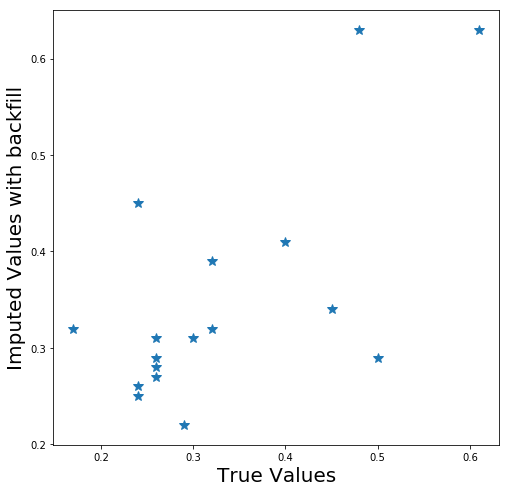

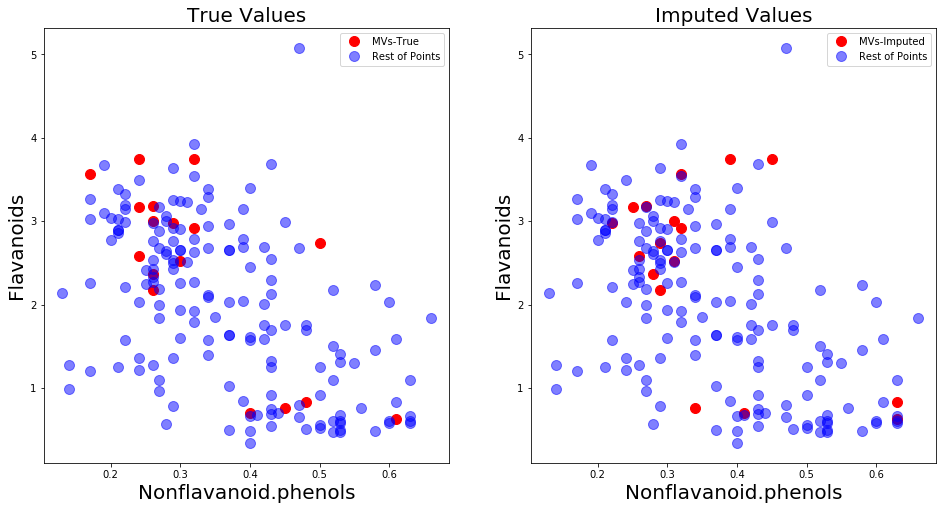

In [5]:
backfilled_data = data.copy().fillna(method='backfill')
inspect_my_method(backfilled_data,chosen_col, true_col, missed_inds,'backfill')

<br> and then **Forward Filling** ...

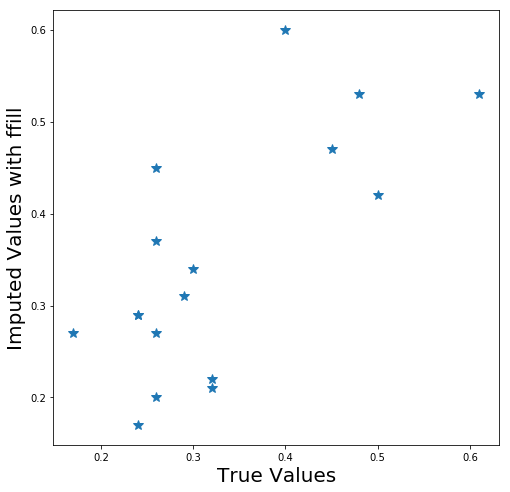

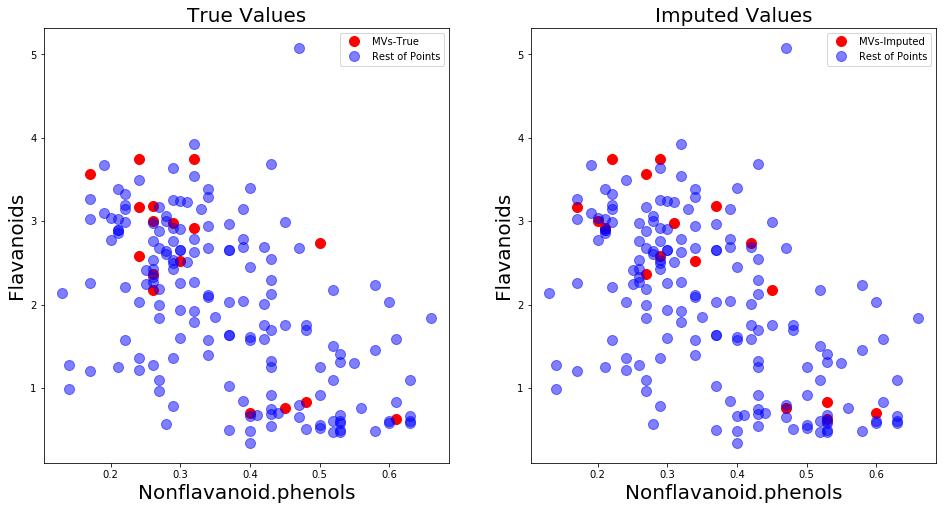

In [6]:
ffilled_data = data.copy().fillna(method='ffill')
inspect_my_method(ffilled_data,chosen_col, true_col, missed_inds, 'ffill')

<br>Backwrad Filling and Forward Filling were *Pandas* methods. For the rest you may use *SKlearn*. In these three methods you can obviouskly see why we said any regression approach (including Correlation analysis which is conceptually close to regression concept) will be heart. <br>The variance of true values is completely killed after imputation.

Filling Missing Values Using mean


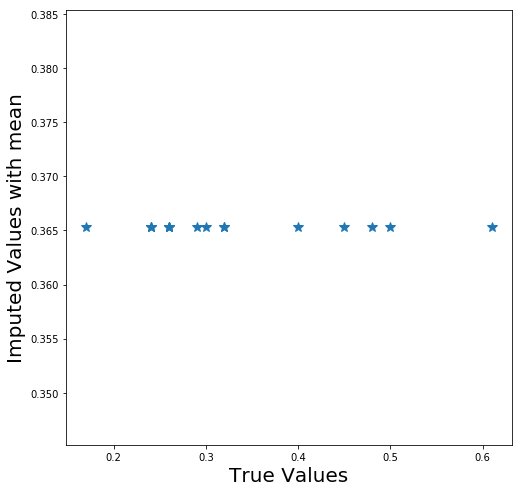

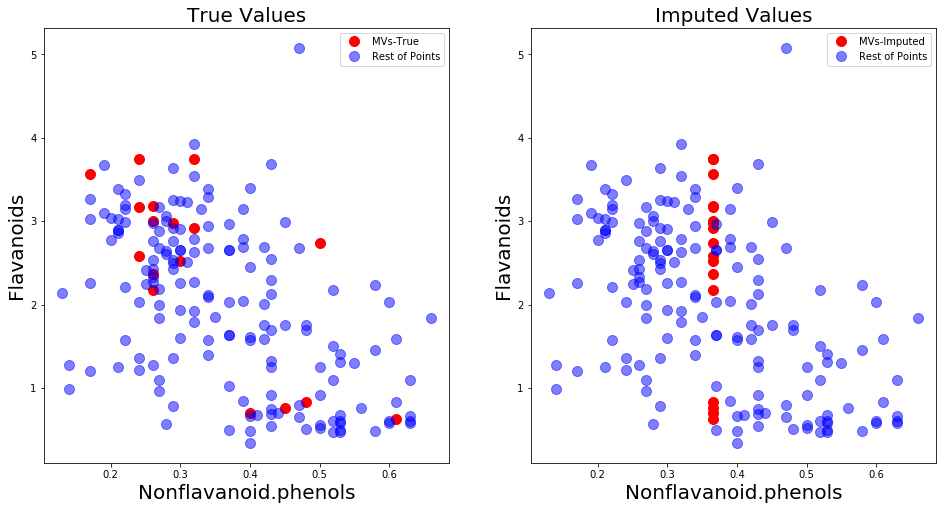

Filling Missing Values Using median


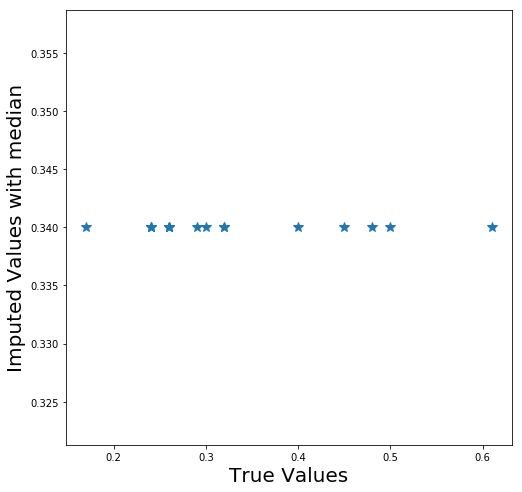

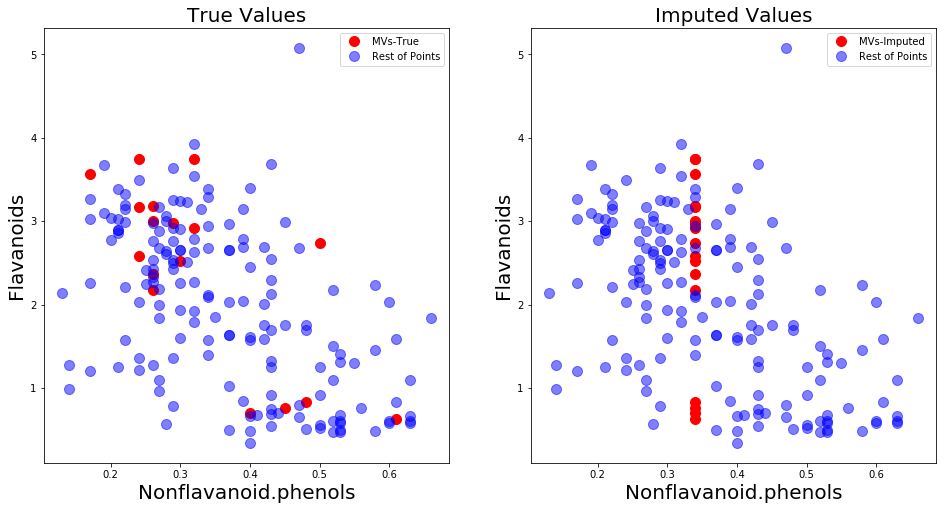

Filling Missing Values Using most_frequent


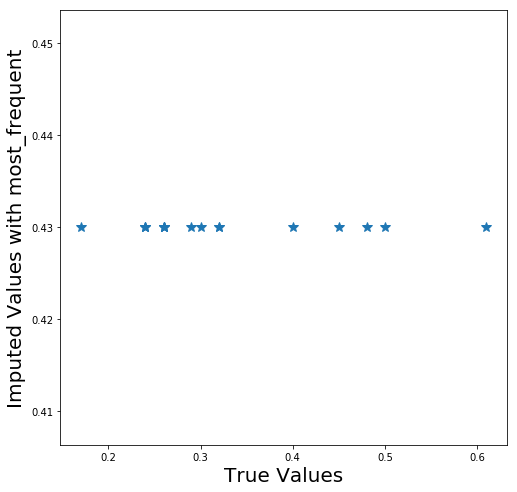

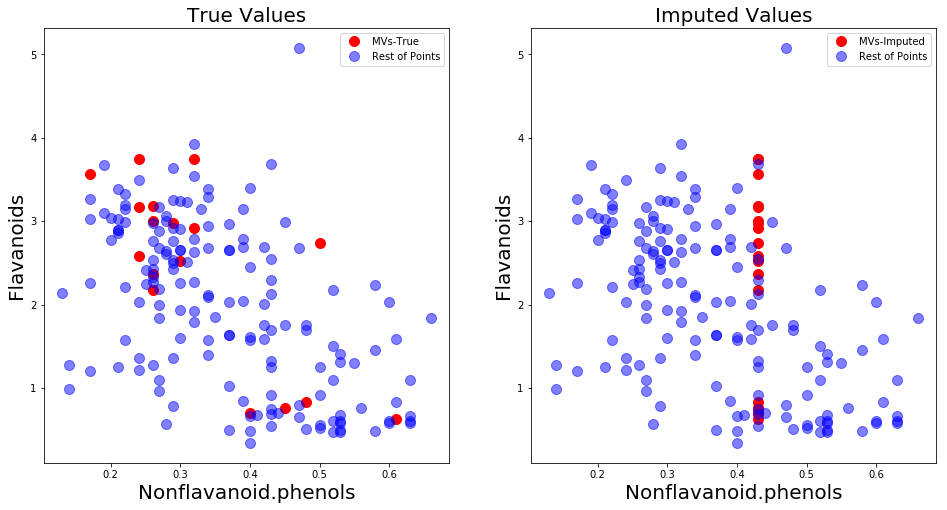

In [7]:
# As the data is numeric, most-frequent equals statistical "Mode"
from sklearn.preprocessing import Imputer
for strat in ['mean','median','most_frequent']:
    print('Filling Missing Values Using '+strat)
    imputer = Imputer(strategy=strat, axis=0)
    imputed_data = data.copy()
    imputed_data[chosen_col] = imputer.fit_transform(data[chosen_col].values.reshape(-1,1))
    inspect_my_method(imputed_data,chosen_col, true_col, missed_inds, strat)
    plt.show()


<br>Let's inspect some correlation. Here you see the difference in feature correlations before and after imputation with only two methods. You may add other methods to the loop to see more.

In [8]:
for col in data.columns:
    if col!=chosen_col:
        print(chosen_col, 'and', col, ',imputed with most frequent: ',   imputed_data[chosen_col].corr(imputed_data[col]))
        print(chosen_col, 'and', col, ',imputed with forward filling: ',   ffilled_data[chosen_col].corr(imputed_data[col]))
        print(chosen_col, 'and', col, ',true value:', data_orig[chosen_col].corr(data_orig[col]))
        print()


Nonflavanoid.phenols and Alcohol ,imputed with most frequent:  -0.12792519935973962
Nonflavanoid.phenols and Alcohol ,imputed with forward filling:  -0.18152320672193056
Nonflavanoid.phenols and Alcohol ,true value: -0.15592946668732913

Nonflavanoid.phenols and Malic.acid ,imputed with most frequent:  0.23924867961762344
Nonflavanoid.phenols and Malic.acid ,imputed with forward filling:  0.294262568999651
Nonflavanoid.phenols and Malic.acid ,true value: 0.292977133480648

Nonflavanoid.phenols and Ash ,imputed with most frequent:  0.13297843814538832
Nonflavanoid.phenols and Ash ,imputed with forward filling:  0.1453803211044561
Nonflavanoid.phenols and Ash ,true value: 0.18623044631692118

Nonflavanoid.phenols and Acl ,imputed with most frequent:  0.2819386073546525
Nonflavanoid.phenols and Acl ,imputed with forward filling:  0.3463617024313217
Nonflavanoid.phenols and Acl ,true value: 0.3619217185576046

Nonflavanoid.phenols and Mg ,imputed with most frequent:  -0.25458362924091227
N

<br><br>
# Multiple Imputation

So far we saw methods which can be used in single and multiple MV imputation by using the info from the feature containing MV. Now we want to generalize the idea in the sense the information from other features help to impute the MVs of one feature. In the most general case we assume multiple imputation in which multiple features have MVs.

This is a simple implementation of MICE just for educative purposes. You may use **mice** functions from **statsmodels** package in **scipy** library.

In [9]:
# We repeat data preparation process to choose several columns for surgery!
data = pd.read_csv('wine.csv').drop('Wine',axis=1)
chosen_cols = np.random.choice(data.columns,3,replace=False).tolist()
missed_inds = {col:np.random.choice(data.index,int(len(data)*.1)).tolist() for col in chosen_cols}
other_inds = {col:[ii for ii in data.index.tolist() if ii not in missed_inds[col]] for col in chosen_cols}
true_cols = data[chosen_cols].copy()
for col in chosen_cols:
    data.loc[missed_inds[col],col] = np.nan
print('Columns',chosen_cols,'have been randomly chosen to have 10% MVs')

Columns ['Flavanoids', 'Phenols', 'OD'] have been randomly chosen to have 10% MVs


For stopping criterion you may choose any convergence measure such as maximum iteration, value change between old and new values in different ways (e.g. using different norms), etc.

Here we simply say the algorithm stops if $\sum(old-new)^2$ is smaller than a threshold.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

def shall_we_stop(old_values, new_values):
    return np.sum((old_values-new_values)**2).sum()

    
def my_mice(data, chosen_cols, missed_inds, thresh):
    init = data.fillna(data.mean()).copy()
    imputed_old = init.copy()
    imputed_new = init.copy()
    cnt = 0
    while True:
        cnt += 1
        for col in chosen_cols:
            target = imputed_old[col].loc[other_inds[col]]
            train = imputed_old[[ii for ii in imputed_old.columns if ii!=col]].loc[other_inds[col]]
            reg =  KernelRidge(alpha=1.0)
            reg.fit(train, target)
            imputed_new[col].loc[missed_inds[col]] = reg.predict(imputed_old[[ii for ii in imputed_old.columns if ii!=col]].loc[missed_inds[col]])
        print(shall_we_stop(imputed_old, imputed_new))    
        if shall_we_stop(imputed_old, imputed_new) < thresh:
            print('Converged!')
            break
        else:
            imputed_old = imputed_new.copy()
    return imputed_new


    

In [13]:
mice_data = my_mice(data, chosen_cols, missed_inds, 0.000001)

25.10857787269083
0.3240409692328084
0.031184572174040075
0.006078220681570558
0.0013347277627370254
0.00034117584580897243
9.93905246223387e-05
2.7676198526913425e-05
8.623993720723982e-06
2.444068365593506e-06
7.701785841344827e-07
Converged!


Flavanoids -----


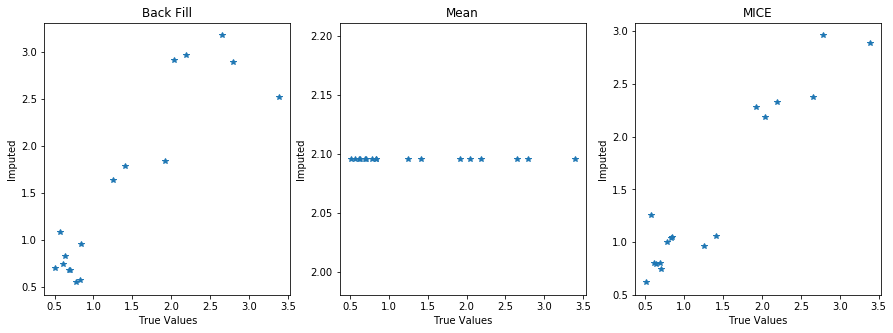




Phenols -----


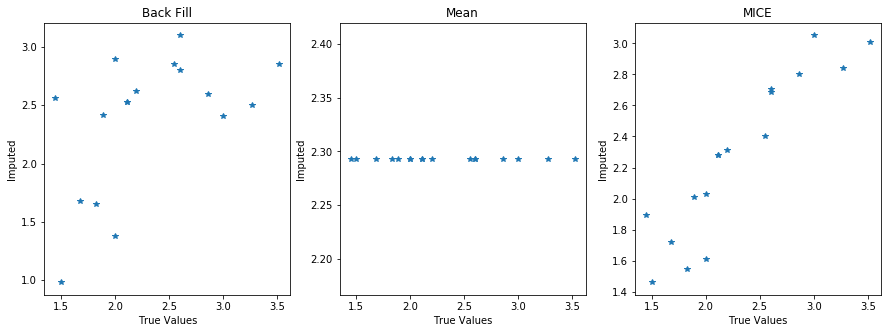




OD -----


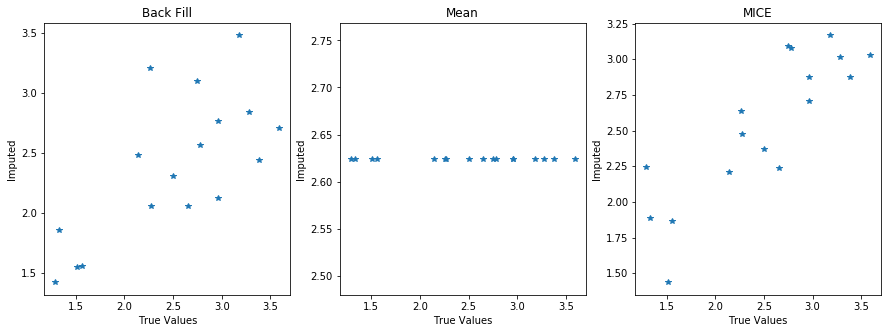

In [14]:
backfilled_data = data.copy().fillna(method='backfill')
imputed_data_mean = data.copy().fillna(data.mean())
titles = {131:'Back Fill', 132:'Mean', 133:'MICE'}
for col in chosen_cols:
    print(col,'-----')
    plt.figure(figsize=(15,5))
    ii = 130
    for d in [backfilled_data,imputed_data_mean,mice_data]:
        ii += 1
        plt.subplot(ii)
        plt.plot(true_cols[col].loc[missed_inds[col]], d[col].loc[missed_inds[col]],'*')
        plt.xlabel('True Values')
        plt.ylabel('Imputed')
        plt.title(titles[ii])
    plt.show()
    print('\n\n')

As seen in plots, the correlation between MICE-imputed MVs and their true values is somehow clear. In case the backward-filling or forward-filling also show correlations, we conclude that data points with same characteristics are arranged next to each other. E.g. in **Flavanoids**, there is a correlation between Back-filled MVs and true values.

# Notes:

-Codes are not supposed to be efficient but illustrative of the problem. Learn the concept and code yourself!

-My stopping criterion in MICE algorithm can be designed more intelligent. For instance see [MissForest, page 4](https://arxiv.org/pdf/1105.0828.pdf).

-In our MICE, we did not try to improve our internal Machine Learning algorithm as the goal was to show the procedure of MICE. You may improve this MICE by:<br>
. **Feature Scaling**: "Proline" is roughly 3000 times larger than "Nonflav.Phenols"!<br>
. **Model Selection 1**: We fitted a model (simplest one) on the observed data and used it for imputation of non-observed. No hyperparameter tuning was applied. Try it!<br>
. **Model Selection 2**: Try more sophisticated regression models and choose the best.<br>
. **Tip**: It means splitting **"the observed"** part of data into train and validation and after choosing the best model apply it to NaN values.
        